<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/neural_evolution_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta
!pip install neat-python


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
use_collab = False
if use_collab:
  csv_dir = '/content/drive/MyDrive/eurusd_hour.csv'
  config_dir = '/content/drive/MyDrive/config-feedforward'
  checkpoint_dir = '/content/drive/MyDrive/neat/newcheckpoint/'
else:
  csv_dir = '/tmp/eurusd_hour.csv'
  config_dir = '/tmp/config-feedforward'
  checkpoint_dir = '/tmp/neatcheckpoint1/'

In [ ]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import multiprocessing
import matplotlib.pyplot as plt
import random
import neat
import string
import gzip
import pickle
import time
import os
from neat.checkpoint import Checkpointer


In [ ]:
def get_relative_change(df, column_name):
    relative_changes = []
    for i in range(len(df)):
        if i == 0:
            relative_changes.append(0)  # First element has no previous value
        else:
            relative_change = (df.iloc[i] - df.iloc[i-1]) / df.iloc[i-1]
            relative_changes.append(relative_change)
    return pd.DataFrame({column_name: relative_changes})

In [ ]:
df = pd.read_csv(csv_dir)
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']


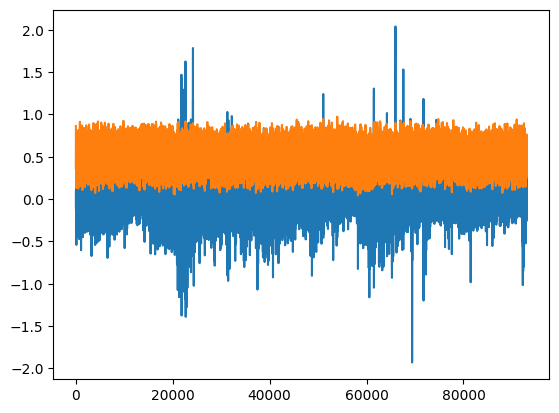

In [ ]:
close_np = close.to_numpy()


# Calculate the rolling velocity
RSI = ta.rsi(close,10,scalar=1)
ROC = ta.roc(close,8,scalar=50)
CHANGE = get_relative_change(close,"Change")

INDICATORS = pd.concat([ROC,RSI,CHANGE],axis=1)

INDICATORS = INDICATORS.dropna(axis=0)
INDICATORS = INDICATORS.reset_index()
INDICATORS.pop('index')

change = INDICATORS.pop('Change')
INDICATORS = INDICATORS.to_numpy()
change = change.to_numpy()
change_dev = change.std()
change = change/change_dev


plt.plot(INDICATORS)

In [ ]:
def softmax(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x))
    return f_x

In [ ]:
def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

In [ ]:
outputs = [.6,.7,.8,.10]
action = outputs[:3]
maxed = np.argmax(action)
print(maxed)

2


In [ ]:
act_check = np.zeros(4)
act_check[1] = 1
act_check[2] = 1

print(np.sum(act_check)==2)

True


In [ ]:
from numpy.random.mtrand import randint
def run_env_loop(net,rand,debug,ep_len,total_val):
    trade_info = np.zeros(6)
    returns = np.array([])
    act_check = np.zeros(4)

    trade_timer = 0
    trade_value = 0.0
    trade_direction = 0
    cash_out_val = 0
    acount_bal = 0
    trade_max = 0
    trade_risk = 0
    time_at_max = 0



    for count in range(rand, rand+ep_len):
        state = np.concatenate((INDICATORS[count],trade_info))
        outputs = net.activate(state)
        risk =  np.clip(abs(outputs[4]), .01, 1)
        action = np.argmax(outputs[:4])
        buy = True if action == 3 else False
        sell = True if action == 2 else False
        cash_out = True if action == 0 else False
        cur_move = change[count+1]
        cash_out_val = 0
        random = randint(0,10)

        if buy:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*1)
          trade_direction = 1
          trade_timer = 0
          trade_max = trade_value
          time_at_max = 0
          act_check[0] = 1
        elif sell:
          cash_out_val = trade_value*trade_risk
          trade_risk = risk
          trade_value = (cur_move*-1)
          trade_direction = -1
          trade_timer = 0
          trade_max = trade_value
          time_at_max = 0
          act_check[1] = 1
        elif cash_out:
          cash_out_val = trade_value*trade_risk
          trade_timer = 0 if trade_direction != 0 else trade_timer+.05
          trade_value = 0
          trade_direction = 0
          trade_max = 0
          time_at_max = 0
          trade_risk = 0
          act_check[2] = 1
        else:
          trade_value += (cur_move*trade_direction)
          trade_timer += .05
          trade_max = max(trade_max,trade_value)
          time_at_max = 0 if trade_value==trade_max else time_at_max+0.05
          act_check[3] = 1



        acount_bal += cash_out_val
        if buy or sell:
          acount_bal -= .1


        trade_info = np.array((trade_value,trade_direction,trade_timer,trade_max,trade_risk,time_at_max))


        if debug:
          print(trade_info)

        if acount_bal<-100:
          return -1
        elif trade_timer>2 and random == 2:
          return -1

    acount_bal += trade_value
    return acount_bal/total_val if np.sum(act_check) == 4 else -1

In [ ]:
def eval_genomes(genomes, config):
  rand = random.randint(1000, 60000)
  ep_len = 1000
  sliced_arr = change[rand:rand+ep_len]
  total_val = sum(abs(sliced_arr))
  for genome_id, genome in genomes:
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    genome.fitness = run_env_loop(net,rand,False,ep_len,total_val)



In [ ]:
def eval_genome_parallel(genome,config):
    ep_len = 1000
    genome.fitness = 0.0
    net = neat.nn.FeedForwardNetwork.create(genome, config)
    fitness = 0
    rand = 0
    for i in range(10):
        sliced_arr = change[rand:rand+ep_len]
        total_val = sum(abs(sliced_arr))
        rand = random.randint(1000, 60000)
        fitness += run_env_loop(net,rand,False,ep_len,total_val)

    return fitness/10


In [ ]:
use_checkpoint = True

config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_dir)
if use_checkpoint:
  checkpoint_file = '/tmp/neatcheckpoint1/594'
  p = Checkpointer.restore_checkpoint(checkpoint_file)
else:
  p = neat.Population(config)


p.add_reporter(neat.StdOutReporter(False))


In [ ]:
p.add_reporter(neat.Checkpointer(generation_interval=100,filename_prefix=checkpoint_dir))

In [ ]:
parallel = True
if parallel:
  pe = neat.ParallelEvaluator(multiprocessing.cpu_count(), eval_genome_parallel)
  winner = p.run(pe.evaluate, 1000000)
else:
  winner = p.run(eval_genomes,1)


 ****** Running generation 5310 ****** 

Population's average fitness: -0.31372 stdev: 0.45475
Best fitness: 0.02855 - size: (15, 19) - species 298 - id 443088
Average adjusted fitness: 0.624
Mean genetic distance 3.543, standard deviation 0.884
Population of 197 members in 13 species
Total extinctions: 0
Generation time: 7.333 sec (7.497 average)
Saving checkpoint to /tmp/neatcheckpoint1/5310

 ****** Running generation 5311 ****** 

Population's average fitness: -0.37150 stdev: 0.47383
Best fitness: 0.02489 - size: (9, 13) - species 299 - id 442822
Average adjusted fitness: 0.577
Mean genetic distance 3.519, standard deviation 0.888
Population of 204 members in 14 species
Total extinctions: 0
Generation time: 6.988 sec (7.470 average)

 ****** Running generation 5312 ****** 

Population's average fitness: -0.36511 stdev: 0.46982
Best fitness: 0.03920 - size: (9, 13) - species 299 - id 442822
Average adjusted fitness: 0.568
Mean genetic distance 3.513, standard deviation 0.878
Popula

In [ ]:
net = neat.nn.FeedForwardNetwork.create(winner, config)
np.set_printoptions(formatter={'float': lambda x: "{:.4f}".format(x)})
rand = random.randint(1000, 60000)
ep_len = 1000
sliced_arr = change[rand:rand+ep_len]
total_val = sum(abs(sliced_arr))
run_env_loop(net,rand,True,ep_len,total_val)

[0.0000 0.0000 0.0500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.1000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.1500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.2000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.2500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.3000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.3500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.4000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.4500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.5000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.5500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.6000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.6500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.7000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.7500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.8000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.8500 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.9000 0.0000 0.0000 0.0000]
[0.0000 0.0000 0.9500 0.0000 0.0000 0.0000]
[0.0000 0.0000 1.0000 0.0000 0.0000 0.0000]
[0.0000 0.0000 1.0500 0.0000 0.0000 0.0000]
[0.0000 0.0000 1.1000 0.0000 0.0000 0.0000]
[0.0000 0.0000 1.1500 0.0000 0.0

-6.898728692969925e-05

In [ ]:


def get_weights(connections, node_name,letter):
    node_weight = ""

    for key, value in connections.items():
        if value.enabled:
            if node_name == letter[value.key[1]]:
                if value.key[0] < 0:
                    from_node_name = "P" + str(value.key[0] * -1)
                    weight = value.weight
                else:
                    from_node_name = letter[value.key[0]]
                    weight = value.weight
                node_weight = node_weight + from_node_name + " * " + str(weight) + " + "


    return(node_weight)





In [ ]:
nodes = winner.nodes
conec = winner.connections
node_list = []
letter_dict = dict()
count = 0



for index, node in nodes.items():
    letter_dict[index] = string.ascii_uppercase[count]
    count += 1

for index, node in nodes.items():
    node_name = letter_dict[index]
    activation = node.activation
    bias = str(node.bias) + ")"
    front = node_name + " = " + activation + "("
    weights = get_weights(conec,node_name,letter_dict)
    node_list.append((front+weights+bias))

node_list.reverse()






In [ ]:
print(winner)

Key: 8665
Fitness: 0.042093639852399736
Nodes:
	0 DefaultNodeGene(key=0, bias=-2.4014173592462527, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=7.062077244536807, response=1.0, activation=relu, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-2.301516838424605, response=1.0, activation=sigmoid, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=4.8297269974819645, response=1.0, activation=sigmoid, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=1.4840953443704485, response=1.0, activation=sigmoid, aggregation=sum)
	19502 DefaultNodeGene(key=19502, bias=-1.6759407651041553, response=1.0, activation=sigmoid, aggregation=sum)
	19959 DefaultNodeGene(key=19959, bias=0.9297216508327579, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-8, 1), weight=0.45782128998925814, enabled=True)
	DefaultConnectionGene(key=(-6, 2), weight=2.0553272799214604, enabled=True)
	DefaultConnectionGene(key=(-6, 19959), weight=1.12657802

In [ ]:
for item in node_list:
       print(item)

G = sigmoid(P6 * 1.1265780277505968 + 0.9297216508327579)
F = sigmoid(-1.6759407651041553)
E = sigmoid(P1 * -0.6388833347750552 + P4 * 0.2511241342079448 + 1.4840953443704485)
D = sigmoid(P5 * -0.732516583862185 + 4.8297269974819645)
C = sigmoid(P6 * 2.0553272799214604 + -2.301516838424605)
B = relu(P5 * -4.177632008758903 + P8 * 0.45782128998925814 + 7.062077244536807)
A = sigmoid(P4 * 0.569279823103827 + P3 * -1.4019660860128094 + G * -0.9755617431087658 + -2.4014173592462527)
